In [42]:
%reload_ext autoreload
%autoreload 3

import matplotlib.pyplot as plt
from nilearn import datasets, image, plotting

import matplotlib.pyplot as plt
import numpy as np
from nilearn import datasets, image, plotting
from nilearn.datasets import load_mni152_template
from nilearn.maskers.nifti_spheres_masker import _apply_mask_and_get_affinity
from nilearn.masking import intersect_masks
from python.acnets.parcellations.dosenbach import load_dosenbach2010_masker
from python.acnets.parcellations.gordon import \
    fetch_atlas as fetch_gordon2014_atlas
from python.acnets.parcellations import seitzman
from tqdm.auto import tqdm

tqdm.pandas()

In [43]:
# load MNI152 template
mni152_template = load_mni152_template(resolution=2)
mni152_data = mni152_template.get_fdata()[..., np.newaxis]
mni152_template = image.new_img_like(mni152_template, mni152_data)

In [44]:
%%script echo skipping...

smith_atlas = datasets.fetch_atlas_smith_2009()
rsn10_img = smith_atlas.rsn10

img = image.index_img(rsn10_img, 3)

coords = plotting.find_xyz_cut_coords(img)
coords

# display = plotting.plot_anat(cut_coords=coords,
#                              title='Regions from this network')

display = plotting.plot_stat_map(img, cut_coords=coords, colorbar=False,
                                 title='Showing one specific network')
# display.add_overlay(img,
#                     cmap=plotting.cm.alpha_cmap('r'))

plotting.show()

skipping...


In [45]:
from python.acnets.parcellations import difumo
difumo_masker, difumo_labels = difumo.load_masker('difumo_64_2mm', None)

difumo_labels['region_index'] = difumo_labels.reset_index().index
difumo_labels['network_index'] = difumo_labels.groupby('network').ngroup()

difumo_maps = image.load_img(difumo_masker.maps_img)


# plotting.plot_prob_atlas(img)
# plotting.show()

def compute_network_mask(regions, atlas='difumo_64_2mm', mni152=None):

    region_idxs = regions['region_index'].to_list()
    _imgs = image.index_img(difumo_maps, region_idxs)
    _imgs = image.binarize_img(_imgs)
    _imgs = list(image.iter_img(_imgs))
    _mask_img = intersect_masks(_imgs, threshold=0, connected=False)

    return _mask_img

    # if 'difumo_64_2mm' in atlas.lower():
    #     network_idx = regions['network_index'].unique()[0]
    #     _mask_img =  image.math_img(f'np.where(img == {network_idx}, 1.0, 0.0)',
    #                                 img=gordon_network_maps)
    #     # _mask = np.where(gordon_network_maps.get_fdata() == network_idx, 1.0, 0.0)
    #     # _mask_img = image.new_img_like(mni152_template, _mask)
    #     _mask_img = image.index_img(_mask_img, 0)

    # return _mask_img


difumo_masks = difumo_labels.groupby('network').progress_apply(compute_network_mask)

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/image/image.py:756: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  return klass(data, affine, header=header)


In [46]:
%%script echo skipping...

# plot DiFuMo networks

for network, _img in difumo_masks.iteritems():
    display = plotting.plot_glass_brain(_img, colorbar=False, title=network)
    plotting.show()

skipping...


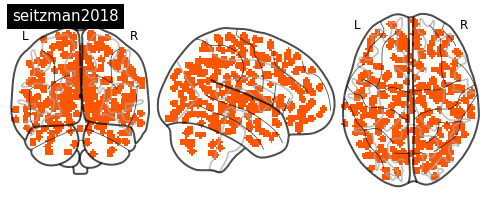

In [47]:
seitzman_masker, seitzman_labels = seitzman.load_masker('seitzman2018', None)
seitzman_labels['network_index'] = seitzman_labels.groupby('network').ngroup()

_, A = _apply_mask_and_get_affinity(seitzman_masker.seeds,
                                    mni152_template,
                                    radius=seitzman_masker.radius,
                                    allow_overlap=seitzman_masker.allow_overlap)
_img = A.toarray().sum(axis=0).reshape(mni152_template.shape)
_img = image.new_img_like(mni152_template, _img)

plotting.plot_glass_brain(_img, title='seitzman2018', colorbar=False)
plt.show()

/usr/local/Caskroom/miniforge/base/envs/acnets/lib/python3.9/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


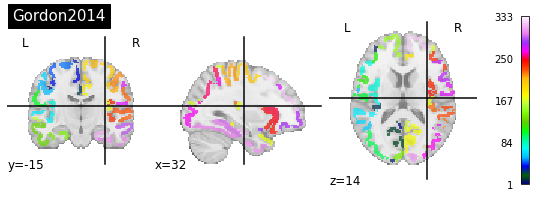

In [48]:
# plot gordon regions

gordon2014_atlas = fetch_gordon2014_atlas()

plotting.plot_roi(gordon2014_atlas.maps, title='Gordon2014', colorbar=True)

plt.show()

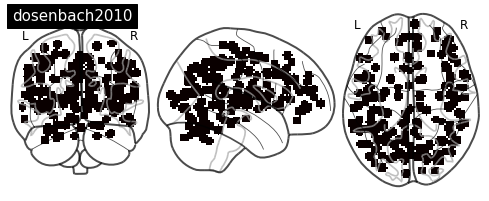

In [49]:
# plot dosenbach regionns

_, dosenbach2010_labels = load_dosenbach2010_masker()
dosenbach2010_labels['network_index'] = dosenbach2010_labels.groupby('network').ngroup()

dosenbach2010_seeds = dosenbach2010_labels[['x','y','z']].values

_, A = _apply_mask_and_get_affinity(dosenbach2010_seeds, mni152_template, radius=5, allow_overlap=False)
_img = A.toarray().sum(axis=0).reshape(mni152_template.shape)
_img = image.new_img_like(mni152_template, _img)

# plotting.plot_roi(_img, title='dosenbach2010', colorbar=False)
# plt.show()
plotting.plot_glass_brain(_img, title='dosenbach2010', colorbar=False)
# plt.show()


In [50]:
# Network Masks

gordon_labels = gordon2014_atlas.labels.reset_index()
gordon_labels['network_index'] = gordon_labels['network'].astype('category').cat.codes + 1

gordon_network_names = gordon_labels.network.astype('category').cat.categories.to_list()

def get_network_index(region_index):
    net_index = 0.0
    if region_index > 0:
        net_index = gordon_labels[['network_index']].values[int(region_index)-1,0]
        net_index = net_index.astype('float')

    return net_index

gordon_network_maps = image.load_img(gordon2014_atlas.maps).get_fdata()
gordon_network_maps = np.vectorize(get_network_index)(gordon_network_maps)
gordon_network_maps = image.new_img_like(gordon2014_atlas.maps, gordon_network_maps)
gordon_network_maps = image.resample_to_img(gordon_network_maps, mni152_template)

In [51]:
def compute_network_mask(regions, atlas, mni152=None):

    if 'gordon2014' in atlas.lower():
        network_idx = regions['network_index'].unique()[0]
        _mask_img =  image.math_img(f'np.where(img == {network_idx}, 1.0, 0.0)',
                                    img=gordon_network_maps)
        # _mask = np.where(gordon_network_maps.get_fdata() == network_idx, 1.0, 0.0)
        # _mask_img = image.new_img_like(mni152_template, _mask)
        _mask_img = image.index_img(_mask_img, 0)

    elif 'dosenbach2010' in atlas.lower():
        seeds = regions[['x','y','z']].values
        _, A = _apply_mask_and_get_affinity(seeds, mni152, radius=5, allow_overlap=False)
        _mask = A.toarray().sum(axis=0).reshape(mni152.shape)
        _mask_img = image.new_img_like(mni152, _mask)

    elif 'seitzman2018' in atlas.lower():
        seeds = regions[['x','y','z']].values
        _, A = _apply_mask_and_get_affinity(seeds, mni152, radius=5, allow_overlap=True)
        _mask = A.toarray().sum(axis=0).reshape(mni152.shape)
        _mask_img = image.new_img_like(mni152, _mask)

    return _mask_img

gordon_network_masks = gordon_labels.groupby('network').progress_apply(
    compute_network_mask, atlas='gordon2014', mni152=mni152_template)

dosenbach_network_masks = dosenbach2010_labels.groupby('network').progress_apply(
    compute_network_mask, atlas='dosenbach2010', mni152=mni152_template)

seitzman_network_masks = seitzman_labels.groupby('network').progress_apply(
    compute_network_mask, atlas='seitzman2018', mni152=mni152_template)

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

In [52]:
%%script echo skipping...
for gnet_name, gnet_mask in tqdm(gordon_network_masks.iteritems(), total=13):
    print(f'{gnet_name}:')
    for dnet_name, dnet_mask in dosenbach_network_masks.iteritems():
        overlap_mask = intersect_masks([gnet_mask, dnet_mask], connected=False)
        overlap_size = image.get_data(overlap_mask).sum()
        if overlap_size >= 40:
            print(f'\t{dnet_name}\t{overlap_size}')
            display = plotting.plot_glass_brain(
                gnet_mask,
                cmap='winter',
                zorder=0,
                title=f'Gordon_{gnet_name} — Dosenbach_{dnet_name}',
                colorbar=False)
            display.add_overlay(dnet_mask, cmap='summer', zorder=1)
            display.add_overlay(overlap_mask, cmap='autumn', zorder=10)
            plt.show()

skipping...


  0%|          | 0/14 [00:00<?, ?it/s]

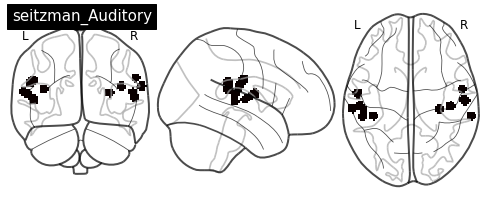

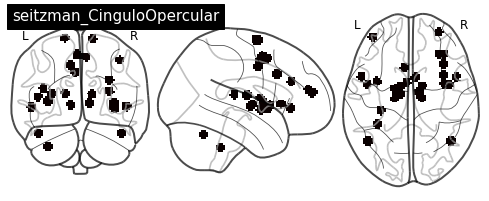

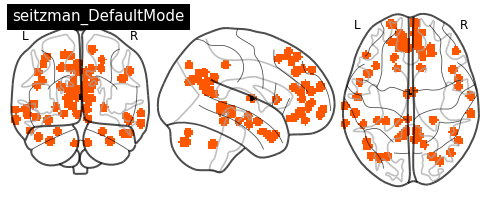

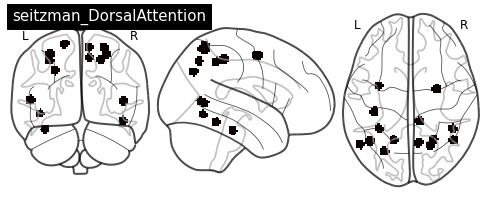

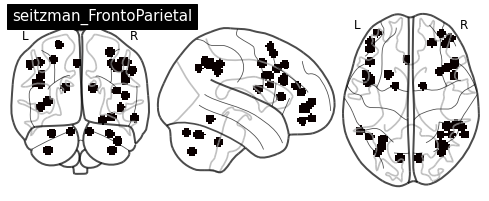

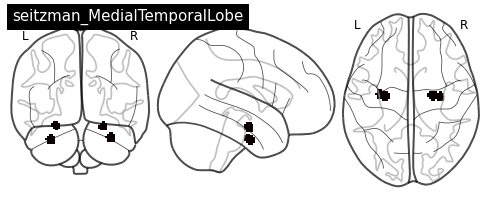

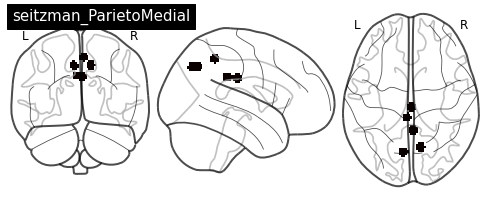

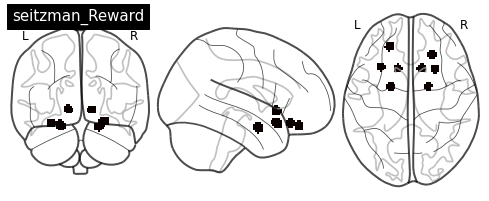

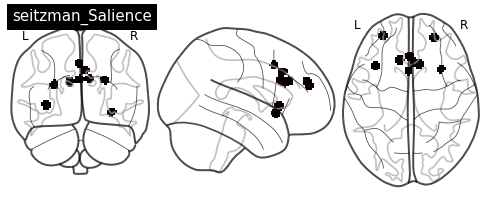

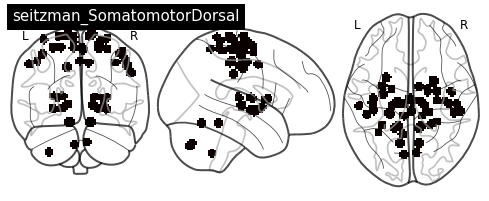

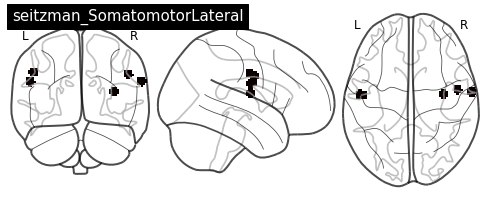

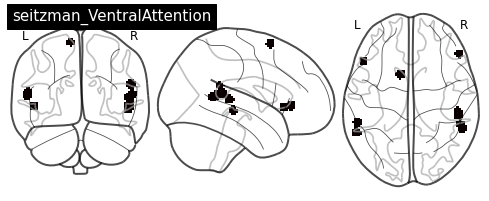

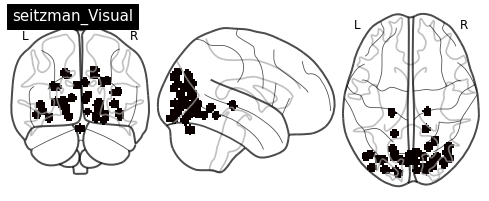

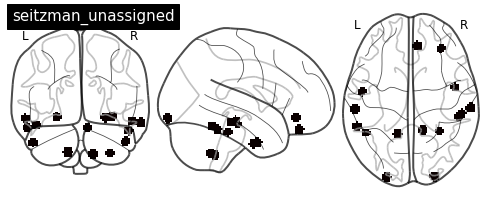

network
Auditory              None
CinguloOpercular      None
DefaultMode           None
DorsalAttention       None
FrontoParietal        None
MedialTemporalLobe    None
ParietoMedial         None
Reward                None
Salience              None
SomatomotorDorsal     None
SomatomotorLateral    None
VentralAttention      None
Visual                None
unassigned            None
dtype: object

In [53]:
def plot_network(network, atlas_name):
    plotting.plot_glass_brain(network.img, title=f'{atlas_name}_{network.name}')
    plt.show()

# dosenbach_network_masks.to_frame('img').progress_apply(
    # plot_network, atlas_name='dosenbach', axis=1)

seitzman_network_masks.to_frame('img').progress_apply(plot_network, atlas_name='seitzman', axis=1)